<a href="https://colab.research.google.com/github/YifanYyds/Deep_Learning_Final/blob/main/Copy_of_SimpleRNN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv("/content/drive/MyDrive/DL_dataset/train_df.csv", header=0, delimiter=",")
val_df = pd.read_csv("/content/drive/MyDrive/DL_dataset/val_df.csv", header=0, delimiter=",")
test_df = pd.read_csv("/content/drive/MyDrive/DL_dataset/test_df.csv", header=0, delimiter=",")


Mounted at /content/drive


In [ ]:
import shutil
import os

# Check if the directory exists
if os.path.exists('my_dir/keras_simple_rnn_tuning'):
    # If it exists, delete it
    shutil.rmtree('my_dir/keras_simple_rnn_tuning')


In [ ]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, SimpleRNN
from keras.callbacks import EarlyStopping

# Prepare the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])

# Ensure all text data is string and handle missing values
train_df['text'] = train_df['text'].astype(str)
val_df['text'] = val_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

# Convert texts to sequences
train_seq = tokenizer.texts_to_sequences(train_df['text'])
val_seq = tokenizer.texts_to_sequences(val_df['text'])
test_seq = tokenizer.texts_to_sequences(test_df['text'])

# Pad sequences
max_length = max(max(len(x) for x in train_seq), max(len(x) for x in val_seq), max(len(x) for x in test_seq))
train_seq_padded = pad_sequences(train_seq, maxlen=max_length)
val_seq_padded = pad_sequences(val_seq, maxlen=max_length)
test_seq_padded = pad_sequences(test_seq, maxlen=max_length)

# Convert labels to one-hot encoding
train_labels = to_categorical(train_df['label'])
val_labels = to_categorical(val_df['label'])
test_labels = to_categorical(test_df['label'])


In [ ]:
import time
from keras.callbacks import Callback
global_epoch_times = []

class TimeHistory(Callback):
    def __init__(self):
        super(TimeHistory, self).__init__()
        self.times = []

    def on_train_batch_begin(self, batch, logs=None):
        self.batch_time_start = time.time()

    def on_train_batch_end(self, batch, logs=None):
        self.times.append(time.time() - self.batch_time_start)

    def on_epoch_end(self, epoch, logs=None):
        average_time_per_batch = sum(self.times) / len(self.times)
        global_epoch_times.append(average_time_per_batch)  # Append to the global list
        self.times = []  # Reset for the next epoch


In [ ]:
import keras_tuner as kt
# Model builder function
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=hp.Int('embedding_output_dim', min_value=64, max_value=128, step=32), input_length=max_length))
    model.add(SimpleRNN(units=hp.Int('rnn_units', min_value=128, max_value=256, step=64)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,  # Number of trials to run
    factor=3,  # Number of models to train per trial
    directory='my_dir',  # Directory to store the tuning logs
    project_name='keras_simple_rnn_tuning'
)

# Instantiate the callbacks
time_history = TimeHistory()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

tuner.search(train_seq_padded, train_labels,
             epochs=10,
             validation_data=(val_seq_padded, val_labels),
             callbacks=[early_stopping, time_history])


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('rnn_units')} and the optimal output dimension of the Embedding layer is {best_hps.get('embedding_output_dim')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
model.fit(train_seq_padded, train_labels, epochs=10, validation_data=(val_seq_padded, val_labels),callbacks=[early_stopping, time_history],batch_size=512)

# Evaluate the model
loss, accuracy = model.evaluate(test_seq_padded, test_labels)
print(f'Test Accuracy: {accuracy:.4f}')

Trial 9 Complete [00h 11m 24s]
val_accuracy: 0.5458213090896606

Best val_accuracy So Far: 0.6205571293830872
Total elapsed time: 01h 50m 34s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal output dimension of the Embedding layer is 128.

Epoch 1/10
61/61 [==============================] - 28s 433ms/step - loss: 1.0706 - accuracy: 0.4112 - val_loss: 1.0083 - val_accuracy: 0.5112
Epoch 2/10
61/61 [==============================] - 27s 448ms/step - loss: 0.7872 - accuracy: 0.6832 - val_loss: 0.8702 - val_accuracy: 0.5927
Epoch 3/10
61/61 [==============================] - 22s 364ms/step - loss: 0.4924 - accuracy: 0.8291 - val_loss: 0.8704 - val_accuracy: 0.6236
Epoch 4/10
61/61 [==============================] - 23s 375ms/step - loss: 0.2462 - accuracy: 0.9261 - val_loss: 0.9851 - val_accuracy: 0.6211
Epoch 5/10
61/61 [==============================] - 23s 377ms/step - loss: 0.1279 - accuracy: 0.9661 - val_lo

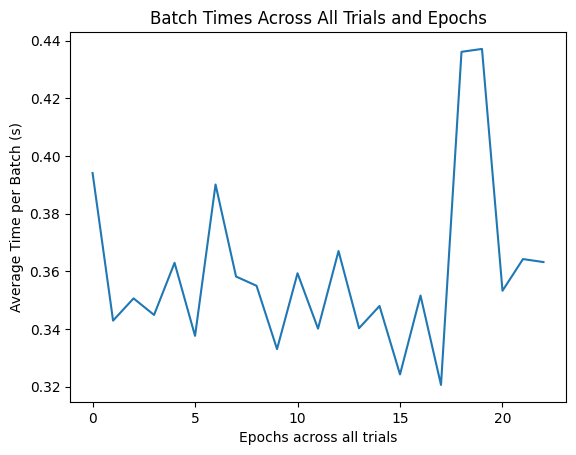

In [ ]:
import matplotlib.pyplot as plt

plt.plot(global_epoch_times)
plt.xlabel('Epochs across all trials')
plt.ylabel('Average Time per Batch (s)')
plt.title('Batch Times Across All Trials and Epochs')
# Save the plot to the Colab VM
plt.savefig('rnn_batch_times.png')

# If using Google Colab and want to save it to Google Drive
from google.colab import drive
drive.mount('/content/drive')
plot_path = '/content/drive/My Drive/rnn_batch_times.png'
plt.savefig(plot_path)
plt.show()


In [ ]:
import pickle

# Serialize and save the variable to a file
with open('/content/drive/My Drive/global_epoch_times.pkl', 'wb') as f:
    pickle.dump(global_epoch_times, f)


In [ ]:
# Assuming test_seq_padded and test_labels are your test sequences and labels
loss, accuracy = model.evaluate(test_seq_padded, test_labels)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


163/163 [==============================] - 6s 40ms/step - loss: 1.1302 - accuracy: 0.6035
Test Loss: 1.1302
Test Accuracy: 0.6035


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Predict the test set
predictions = model.predict(test_seq_padded)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Calculate additional metrics
print(classification_report(true_classes, predicted_classes))
print(confusion_matrix(true_classes, predicted_classes))


NameError: ignored

In [ ]:
# Save the entire model to a file
model.save('my_rnn_model.h5')  # Saves to the Colab VM

# If using Google Colab, save it to Google Drive by mounting the drive first
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/My Drive/my_rnn_model.h5'
model.save(model_path)
